In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [54]:
# --- 1. Configuration et Chargement du Modèle ---

# Charger le modèle ResNet50 pré-entraîné sur ImageNet
model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=True)
model.trainable = False # Geler le modèle, nous n'optimisons que le masque

# Définir la taille d'entrée attendue par ResNet50
IMG_SIZE = (224, 224)

# --- 2. Chargement et Préparation de l'Image (x) ---

# Télécharger une image d'exemple
img_url = "data/elephant.jpg"

# Charger l'image et la redimensionner
img = tf.keras.utils.load_img(img_url, target_size=IMG_SIZE)
# 'x' est notre image de base (0-255), de forme (224, 224, 3)
x = tf.keras.utils.img_to_array(img)
x = tf.constant(x) # On le convertit en tenseur pour ne pas qu'il soit modifié lors du pré-traitement

# Fonction pour pré-traiter l'image pour ResNet50
def preprocess_image(img_tensor):
    # Ajoute la dimension batch et applique le pré-traitement ResNet
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_tensor[tf.newaxis, ...])

# --- 3. Obtenir la Prédiction Originale (Phi(x)) ---

# Pré-traiter l'image originale
x_preprocessed = preprocess_image(x)

# Obtenir les prédictions (qui sont des probabilités)
original_preds = model(x_preprocessed, training=False)

# Obtenir le vecteur de probabilités (en enlevant la dimension batch)
original_probs = original_preds[0]

# Obtenir l'index (j*) de la classe prédite
j_star = tf.argmax(original_probs)

# Obtenir la probabilité de cette classe
original_prob_value = original_probs[j_star]

# --- Le reste est pour l'affichage ---

# Décodage pour affichage des noms
decoded_preds = tf.keras.applications.mobilenet_v3.decode_predictions(original_preds.numpy(), top=5)

print("Les 5 meilleures prédictions pour l'image :")
for i in range(5):
    class_name = decoded_preds[0][i][1]
    prob = decoded_preds[0][i][2]
    print(f"  {i+1}. {class_name} : {prob:.4f}")

# Afficher la prédiction principale qui sera utilisée pour RDE
# (On a besoin de .numpy() pour l'afficher proprement dans le f-string)
print(f"\nPrédiction principale (utilisée pour RDE) : {decoded_preds[0][0][1]} (Classe {j_star}) avec probabilité {original_prob_value.numpy():.4f}")

Les 5 meilleures prédictions pour l'image :
  1. tusker : 0.5373
  2. Indian_elephant : 0.4138
  3. African_elephant : 0.0124
  4. Great_Dane : 0.0006
  5. volcano : 0.0006

Prédiction principale (utilisée pour RDE) : tusker (Classe 101) avec probabilité 0.5373


In [ ]:
# --- Hyperparamètres ---
C = 100.0
lambda_val = 0.6
num_steps = 2000
num_samples = 64
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

# Le masque entraînable
mask_shape = (x.shape[0], x.shape[1], 1)
s = tf.Variable(tf.ones(shape=mask_shape), trainable=True)

# Moyenne et écart-type pour le bruit v 
mu = tf.reduce_mean(x)
sigma = tf.math.reduce_std(x)

# --- Boucle d'optimisation ---

print("Début de l'optimisation RDE (Pixel RDE)...")

for step in tqdm(range(num_steps)):
    
    # On crée UNE SEULE "tape" pour TOUS les échantillons
    with tf.GradientTape() as tape:
        
        # 1. Garder le masque s dans [0, 1]
        s.assign(tf.clip_by_value(s, 0, 1))
        
        # 2. Estimer l'espérance de la distorsion (Monte-Carlo)
        distortion = 0.0
        for _ in range(num_samples):
            # Générer le bruit v
            v = tf.random.normal(shape=x.shape, mean=mu, stddev=sigma, dtype=tf.float32)
            
            # Créer l'entrée perturbée y
            y = x * s + (1 - s) * v
            y = tf.clip_by_value(y, 0, 255)
            
            # Pré-traiter l'image perturbée
            y_preprocessed = preprocess_image(y) 
            
            # Obtenir la prédiction (probabilités)
            perturbed_output = model(y_preprocessed, training=False)
            
            # Obtenir la probabilité pour la classe d'origine j*
            perturbed_prob = perturbed_output[0, j_star]
            
            # Calculer la distorsion
            distortion += tf.square(original_prob_value - perturbed_prob)
            
        # Moyenne de la distorsion
        D = distortion / num_samples
        
        # 3. Calculer la pénalité de parcimonie (R)
        R = lambda_val * tf.norm(s, ord=1) # Norme L1
        
        # 4. Perte totale
        total_loss = C * D + R
        # La "tape" a enregistré les 64 calculs + la moyenne + la norme L1

    # 5. Rétropropagation
    # Calcule le gradient de la perte totale par rapport à 's'
    gradients = tape.gradient(total_loss, [s])
    
    # Applique les gradients à 's'
    optimizer.apply_gradients(zip(gradients, [s]))

print("Optimisation terminée.")

# 6. Le résultat final est le masque 's' optimisé
s.assign(tf.clip_by_value(s, 0, 1)) # Nettoyer le masque final
final_mask = s.numpy() # Convertit en array NumPy

Début de l'optimisation RDE (Pixel RDE)...


100%|██████████| 300/300 [1:24:17<00:00, 16.86s/it]    

Optimisation terminée.


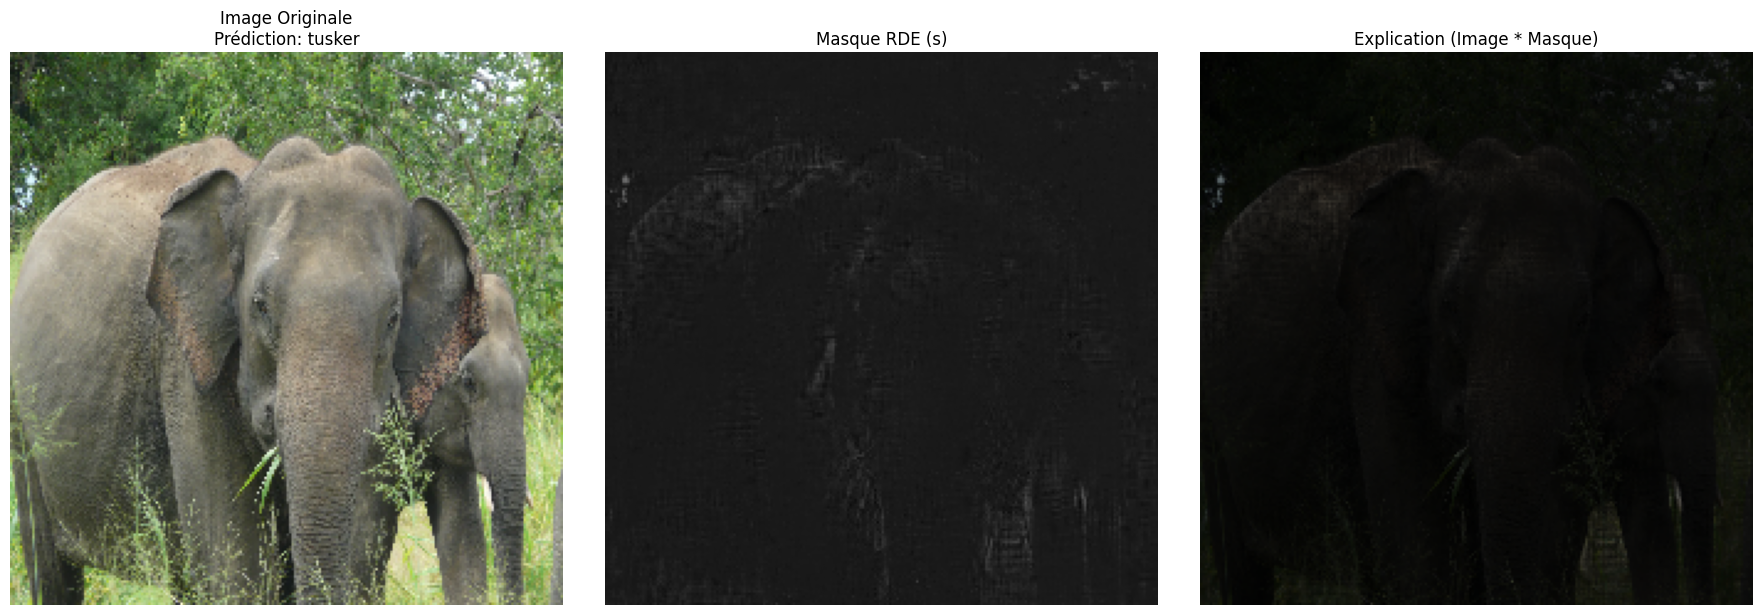

In [56]:
# --- 1. Préparation ---

# Image originale en uint8 (0-255)
original_image = x.numpy().astype(np.uint8)

# Image d'explication en uint8 (0-255)
explanation_image = (original_image * final_mask).astype(np.uint8)

# --- 2. Création de la visualisation ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# --- Image Originale ---
ax1.imshow(original_image)
ax1.set_title(f"Image Originale\nPrédiction: {decoded_preds[0][0][1]}")
ax1.axis('off')

# --- Masque RDE ---
ax2.imshow(final_mask, cmap='gray', vmin=0, vmax=1)
ax2.set_title("Masque RDE (s)")
ax2.axis('off')

# --- Explication (Image * Masque) ---
ax3.imshow(explanation_image)
ax3.set_title("Explication (Image * Masque)")
ax3.axis('off')

plt.tight_layout()
plt.show()